# Facenet study on CIFAR-10 dataset

In [1]:
import keras
from keras.layers import (Input, Dense, Flatten, Conv2D, LeakyReLU, Conv2DTranspose,
                          BatchNormalization, GlobalAveragePooling2D, Lambda)
from keras.models import Model
from keras import backend as K
import numpy as np

/root/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
K.image_data_format()

'channels_last'

In [3]:
# input MNIST image dimensions as K.image_data_format() = 'channels_last'
img_rows, img_cols, channels = 32, 32, 3 # as CIFAR-10
input_shape = (img_rows, img_cols, channels)

In [4]:
import tensorflow as tf

# Copied from https://github.com/Skuldur/facenet-face-recognition/blob/9b9538252ad5dfe1e498720c4b1731612ca35e9c/facenet.py#L21
def triplet_loss(y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- Not used.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 32)
            positive -- the encodings for the positive images, of shape (None, 32)
            negative -- the encodings for the negative images, of shape (None, 32)
    
    Returns:
    loss -- real number, value of the loss
    """

    anchor, positive, negative = y_pred
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)

    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha) # d(a, p) - d(a, n)
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0)) # sum(max(basic_loss, 0))

    print(loss)
    return loss

In [5]:
# FaceNet paper used "Local response normalization",
# but Keras doesn't support as it is not effective and not used often
def get_shared_model(input_shape):
    base_net = keras.applications.vgg19.VGG19(
#     base_net = keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet'
    ) # width and height must be no smaller than 75 px. input channels must be 3.
    
    # Upsample input as its size is too small for inception v3
    inputs = Input(shape=input_shape)
    hid = BatchNormalization(epsilon=0.00001)(inputs)
    hid = Conv2DTranspose(filters=3, kernel_size=[2,2], strides=[2,2], padding='valid')(hid)
    hid = LeakyReLU(alpha=0.02)(hid)
    hid = BatchNormalization(epsilon=0.00001)(hid)
    hid = Conv2DTranspose(filters=3, kernel_size=[2,2], strides=[2,2], padding='valid')(hid)
    hid = LeakyReLU(alpha=0.02)(hid)
    hid = BatchNormalization(epsilon=0.00001)(hid)

    hid = base_net(hid)

    hid = GlobalAveragePooling2D()(hid)
    hid = Dense(128)(hid)
    L2_normalized = Lambda(lambda x: K.l2_normalize(x,axis=1))(hid)
    
    shared_model = Model(inputs=inputs, outputs=L2_normalized)

    return shared_model

In [6]:
# anc, pos, neg are supposed to be Input()
def get_triplet_model(input_shape, triplet_loss):
    shared_model = get_shared_model(input_shape)
    anc_input = Input(input_shape)
    pos_input = Input(input_shape)
    neg_input = Input(input_shape)

    anc_output = shared_model(anc_input)
    pos_output = shared_model(pos_input)
    neg_output = shared_model(neg_input)

    outputs = anc_output, pos_output, neg_output
    
    triplet_model = Model(
        inputs = [anc_input,  pos_input,  neg_input],
        outputs= [anc_output, pos_output, neg_output]
    )
    triplet_model.add_loss(K.mean(triplet_loss(outputs)))

    return shared_model, triplet_model

In [7]:
shared_model, triplet_model = get_triplet_model(input_shape, triplet_loss)
shared_model.summary()

Tensor("Sum_2:0", shape=(), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 3)         39        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 128, 128, 3)       39        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (Non

In [8]:
triplet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          20090162    input_3[0][0]                    
                                                                 input_4[0][0]                    
          

In [9]:
# No accuracy is needed as an output doesn't have any correct vector
# Triplet loss needed to be added on building a model as outputs shares objective function,
# Keras doesn't support to handle it at model.compile
triplet_model.compile(optimizer='sgd', loss=None)

In [10]:
# --------
# batch generator
# --------


# this kaggle page helped me
# https://www.kaggle.com/guichristmann/training-a-triplet-loss-model-on-mnist
def reorganize_data(X, y):
    assert X.shape[0] == y.shape[0]
    
    data_dict = {i: [] for i in range(10)}
    for i in range(X.shape[0]):
        data_dict[y[i][0]].append(X[i])
        
    return data_dict

import random

def generate_triplet_batch(data_dict, batch_size=32):
    """
    Pick ten sets of (anchor, positive, negative) up randomly from each class
    model.fit_generator expects generator to return (inputs, targets). On facenet,
    inputs is (anc, pos, neg), and targets is None.
    """
    anc_batch_temp = []
    pos_batch_temp = []
    neg_batch_temp = []
    
    classes = [i for i in range(10)]
    
    dummy = np.zeros((batch_size, 32))
    
    while True:
        anc_y = random.choice(classes)
        list_except_anc = [i for i in range(10) if i != anc_y]
        neg_y = random.choice(list_except_anc)
        
        anc, pos = random.sample(data_dict[anc_y], 2)
        neg = random.choice(data_dict[neg_y])
        
        anc_batch_temp.append(anc)
        pos_batch_temp.append(pos)
        neg_batch_temp.append(neg)
                
        if len(anc_batch_temp) == batch_size:
            anc_batch, anc_batch_temp = anc_batch_temp, []
            pos_batch, pos_batch_temp = pos_batch_temp, []
            neg_batch, neg_batch_temp = neg_batch_temp, []  
            
            anc_batch = np.array(anc_batch)
            pos_batch = np.array(pos_batch)
            neg_batch = np.array(neg_batch)
        
            yield [anc_batch, pos_batch, neg_batch], None

In [11]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data() # (#channel, 28, 28)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)

# Prepare reorganized dict data
train_data_dict = reorganize_data(X_train, y_train)
test_data_dict = reorganize_data(X_test, y_test)

X_train shape:  (50000, 32, 32, 3)
y_train shape:  (50000, 1)


In [12]:
# --------
# Functions and class to plot training process
# --------

from sklearn.manifold import TSNE


def reduce_dimention(L2_normed):
    return TSNE(n_components=2, random_state=0).fit_transform(L2_normed)


def scale_value(x, in_min, in_max, out_min, out_max):
    """
    canvas has its own size (canvas_x_min, canvas_y_min), (canvas_y_min, canvas_y_max)
    reduced corrdinates also has its own min and max. This function scales coordinates to fit canvas.
    """
    return out_min + (x - in_min) * (out_max - out_min) / (in_max - in_min)


def plot_images(images, xy, canvas_shape=(512,512), fill=0):    
    h, w = images.shape[1:3]
    if images.ndim == 4:
        canvas_shape = (canvas_shape[0], canvas_shape[1], images.shape[3])
    
    min_xy = np.amin(xy, 0)
    max_xy = np.amax(xy, 0)
    
    min_canvas_drawable = np.array((0, 0))
    max_canvas_drawable = np.array((canvas_shape[0] - h, canvas_shape[1] - w))
    # -h, -w so that max(reduced_x, reduced_ y) shodn't exceed the canvas
    
    canvas = np.full(canvas_shape, 255)
    for image, pos in zip(images, xy):
        x_off, y_off = scale_value(pos, min_xy, max_xy, min_canvas_drawable, max_canvas_drawable).astype(int)
#         sub_canvas = canvas[y_off:y_off+h, x_off:x_off+w]
#         sub_image = image[:h, :w]
#         canvas[y_off:y_off+h, x_off:x_off+w] = blend(sub_canvas, sub_image)
# Above code is good for MNIST as they get overlayed, but CIFAR-10 is all painted.
        canvas[y_off:y_off+h, x_off:x_off+w] = image[:h, :w]

    return canvas


from io import BytesIO
import numpy as np
import PIL.Image
import IPython.display
import shutil
import os


def show_array(a, fmt='png', filename=None, retina=False, zoom=None):
    if len(a.shape) == 1:
        n = len(a)
        side = int(math.sqrt(n))
        if (side * side) == n:
            a = a.reshape(side, side)
        else:
            raise ValueError('input is one-dimensional', a.shape)
    a = np.uint8(np.clip(a, 0, 255))
    image_data = BytesIO()
    PIL.Image.fromarray(a).save(image_data, fmt)
    if filename is None:
        height, width = a.shape[:2]
        if zoom is not None:
            width *= zoom
            height *= zoom
        IPython.display.display(
            IPython.display.Image(
                data=image_data.getvalue(),
                width=width,
                height=height,
                retina=retina
             )
        )
    else:
        with open(filename, 'wb') as f:
            image_data.seek(0)
            shutil.copyfileobj(image_data, f)


class Plot(keras.callbacks.Callback):
    
    def __init__(self, embedding_model, model_input, plot_size=None, is_saved=True):
        self.embedding_model = embedding_model
        self.model_input = model_input[:plot_size] if plot_size else model_input
        self.plot_size = plot_size
        self.is_saved = is_saved
        if self.is_saved and not os.path.exists('img'):
            os.mkdir('img')
    
    def on_epoch_end(self, epoch, logs={}):
        embedded_L2 = self.embedding_model.predict(self.model_input)
        reduced = reduce_dimention(embedded_L2)
        canvas_array = plot_images(self.model_input.squeeze(), reduced)
        if self.is_saved:       
            show_array(a=canvas_array, filename='img/{:0=3}-{:.3f}.png'.format(epoch + 1, logs['val_loss']))
        else:
            IPython.display.clear_output(wait=True)
            show_array(a=canvas_array)
            

In [13]:
triplet_model.metrics_names

['loss']

In [14]:
EPOCHS = 200
BATCH_SIZE = 32
STEPS_PER_EPOCH = int(X_train.shape[0] // BATCH_SIZE)
VALIDATION_STEPS = int(X_test.shape[0] // BATCH_SIZE)
NUM_TO_PLOT = 1024

In [15]:
import datetime
print(datetime.datetime.now())

2018-10-26 11:08:05.149929


In [16]:
callback_plt = Plot(shared_model, X_test, NUM_TO_PLOT)
callback_tb = keras.callbacks.TensorBoard(log_dir='log', histogram_freq=0,  
          write_graph=True, write_images=True)
history = keras.callbacks.History()

if not os.path.exists('log'):
    os.mkdir('log')

triplet_model.fit_generator(
    generator=generate_triplet_batch(train_data_dict, BATCH_SIZE),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    verbose=1,
    validation_data=generate_triplet_batch(test_data_dict, BATCH_SIZE),
    validation_steps=VALIDATION_STEPS,
    callbacks=[callback_plt, callback_tb, history]
)

Epoch 1/200
1562/1562 [==============================] - 815s 522ms/step - loss: 6.3720 - val_loss: 6.3160
Epoch 2/200
1562/1562 [==============================] - 804s 515ms/step - loss: 6.0733 - val_loss: 5.9189
Epoch 3/200
1562/1562 [==============================] - 804s 515ms/step - loss: 5.5142 - val_loss: 6.3846
Epoch 4/200
1562/1562 [==============================] - 804s 515ms/step - loss: 5.1648 - val_loss: 5.1448
Epoch 5/200
1562/1562 [==============================] - 804s 515ms/step - loss: 4.9520 - val_loss: 4.6692
Epoch 6/200
1562/1562 [==============================] - 804s 515ms/step - loss: 4.5844 - val_loss: 4.4407
Epoch 7/200
1562/1562 [==============================] - 804s 515ms/step - loss: 4.2268 - val_loss: 4.1160
Epoch 8/200
1562/1562 [==============================] - 805s 515ms/step - loss: 3.8698 - val_loss: 3.6453
Epoch 9/200
1562/1562 [==============================] - 804s 515ms/step - loss: 3.5290 - val_loss: 3.4039
Epoch 10/200
1562/1562 [=============

Epoch 77/200
1562/1562 [==============================] - 798s 511ms/step - loss: 0.0333 - val_loss: 0.8610
Epoch 78/200
1562/1562 [==============================] - 798s 511ms/step - loss: 0.0336 - val_loss: 0.8708
Epoch 79/200
1562/1562 [==============================] - 799s 512ms/step - loss: 0.0315 - val_loss: 0.9496
Epoch 80/200
1562/1562 [==============================] - 799s 512ms/step - loss: 0.0274 - val_loss: 0.8302
Epoch 81/200
1562/1562 [==============================] - 799s 512ms/step - loss: 0.0300 - val_loss: 0.9198
Epoch 82/200
1562/1562 [==============================] - 800s 512ms/step - loss: 0.0308 - val_loss: 0.9793
Epoch 83/200
1562/1562 [==============================] - 800s 512ms/step - loss: 0.0252 - val_loss: 0.9009
Epoch 84/200
1562/1562 [==============================] - 800s 512ms/step - loss: 0.0234 - val_loss: 0.8663
Epoch 85/200
1562/1562 [==============================] - 800s 512ms/step - loss: 0.0231 - val_loss: 0.9621
Epoch 86/200
1562/1562 [====

1562/1562 [==============================] - 795s 509ms/step - loss: 0.0070 - val_loss: 0.9117
Epoch 153/200
1562/1562 [==============================] - 795s 509ms/step - loss: 0.0087 - val_loss: 0.8274
Epoch 154/200
1562/1562 [==============================] - 795s 509ms/step - loss: 0.0071 - val_loss: 0.8615
Epoch 155/200
1562/1562 [==============================] - 795s 509ms/step - loss: 0.0068 - val_loss: 0.9682
Epoch 156/200
1562/1562 [==============================] - 795s 509ms/step - loss: 0.0098 - val_loss: 6.4000
Epoch 157/200
1562/1562 [==============================] - 795s 509ms/step - loss: 0.0101 - val_loss: 0.8752
Epoch 158/200
1562/1562 [==============================] - 795s 509ms/step - loss: 0.0083 - val_loss: 0.8945
Epoch 159/200
1562/1562 [==============================] - 795s 509ms/step - loss: 0.0068 - val_loss: 0.8688
Epoch 160/200
1562/1562 [==============================] - 795s 509ms/step - loss: 0.0124 - val_loss: 0.9043
Epoch 161/200
1562/1562 [========

In [17]:
print(datetime.datetime.now())

2018-10-28 08:13:58.605598


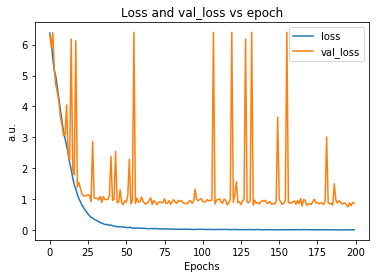

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('a.u.')
plt.title('Loss and val_loss vs epoch')
plt.show()

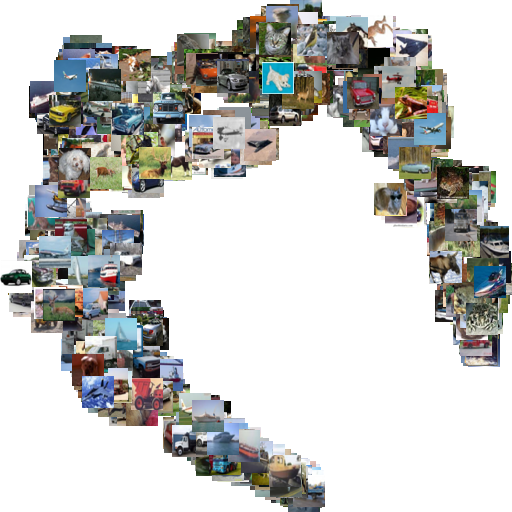

In [23]:
IPython.display.Image(filename='img/001-6.316.png')

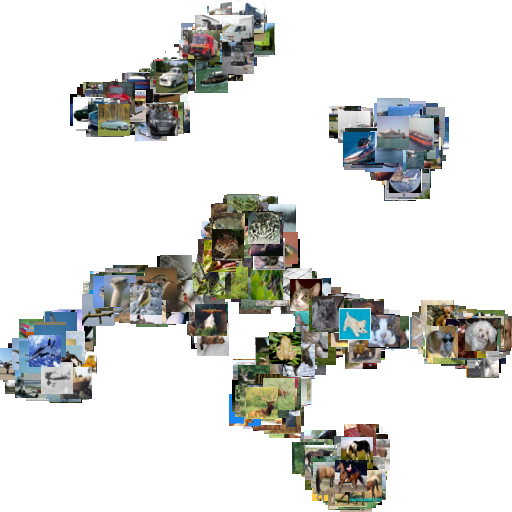

In [24]:
IPython.display.Image(filename='img/050-0.952.png')

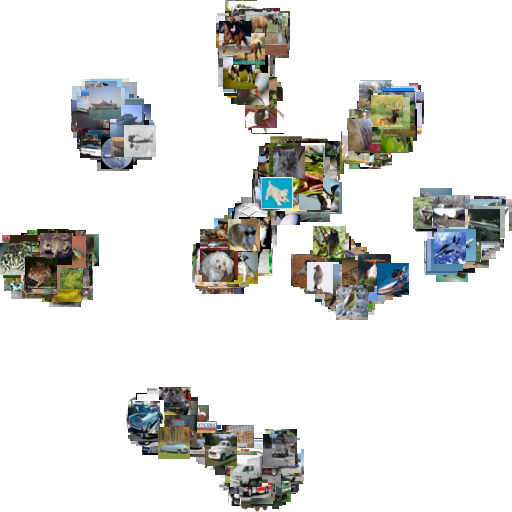

In [25]:
IPython.display.Image(filename='img/100-1.015.png')

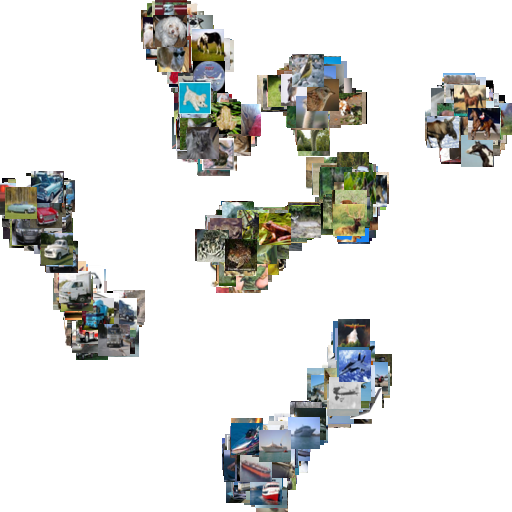

In [27]:
IPython.display.Image(filename='img/196-0.746.png')